<a href="https://colab.research.google.com/github/kavithachitriki/OCRProject/blob/main/EMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2 as cv
import matplotlib.pyplot as plt

# Image preprocessing module
from PIL import Image, ImageFilter

In [2]:
# Import modules
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

#keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy

In [3]:
pip install emnist

In [4]:
from emnist import list_datasets
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [32]:
from emnist import extract_training_samples
images_train, labels_train = extract_training_samples('letters')
from emnist import extract_test_samples
images_test, labels_test = extract_test_samples('letters')


In [25]:
print("Train: %s, Test: %s" %(images_train.shape, images_test.shape))

Train: (124800, 28, 28), Test: (20800, 28, 28)


In [26]:
    mapp = pd.read_csv(
    r'emnist-letters-mapping.txt',
    delimiter=' ',
    index_col=0,
    header=None,
    squeeze=True
)

In [15]:
HEIGHT = 28
WIDTH = 28

In [27]:
# Flatten Data
#dims = images_train.shape[1] * images_train.shape[2]
#X_train = images_train.reshape(images_train.shape[0], dims)
#X_test = images_test.reshape(images_test.shape[0], dims)
#print("Training Shape:", X_train.shape)
#print("Testing Shape:", X_test.shape)

Training Shape: (124800, 784)
Testing Shape: (20800, 784)


In [35]:
# Rescale to 0 -> 1 by dividing by max pixel value (255)
X_train = images_train.astype('float32')/255
X_test = images_test.astype('float32')/255
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

Training Shape: (124800, 28, 28)
Testing Shape: (20800, 28, 28)


In [36]:
train_x = X_train
train_y = labels_train


test_x = X_test
test_y = labels_test


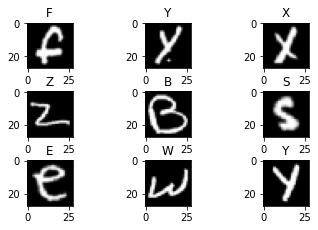

In [37]:
for i in range(100,109):
  plt.subplot(330 + (i+1))
  plt.subplots_adjust(hspace=0.5, top=1)
  plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
  plt.title(chr(mapp.iloc[train_y[i]-1,0]))

In [40]:
num_classes = 26

In [41]:
train_y = to_categorical(labels_train-1, num_classes)
test_y = to_categorical(labels_test-1, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (124800, 26)
test_y:  (20800, 26)


In [42]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, 
                                                  train_y, 
                                                  test_size=0.10, 
                                                  random_state=7)

print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

(112320, 28, 28) (12480, 28, 28) (112320, 26) (12480, 26)


In [43]:
# Reshape
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)
val_x = val_x.reshape(-1, HEIGHT, WIDTH, 1)

In [44]:
# Create more images via data augmentation
datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.10,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_gen = datagen.flow(train_x, train_y, batch_size=64)
val_gen = datagen.flow(val_x, val_y, batch_size=64)

In [45]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))


model.add(Conv2D(128, kernel_size=4, activation='relu'))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(units=num_classes, activation='softmax'))

input_shape = (None, HEIGHT, WIDTH, 1)
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

In [ ]:
  
my_callbacks = [
    # Decrease learning rate
    LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x),
    # Training will stop there is no improvement in val_loss after 3 epochs
    EarlyStopping(monitor="val_acc", 
                  patience=3, 
                  mode='max', 
                  restore_best_weights=True)
]

# def top_3_accuracy(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=3)


# TRAIN NETWORKS
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# history = model.fit(train_x, train_y, 
#                     epochs=100,
#                     verbose=1, validation_data=(val_x, val_y), 
#                     callbacks=my_callbacks)

# With datagen
history = model.fit_generator(train_gen, steps_per_epoch=train_x.shape[0]//64, epochs=100,
                              validation_data=val_gen, validation_steps=val_x.shape[0]//64, callbacks=my_callbacks)
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
1755/1755 [==============================] - 492s 280ms/step - loss: 1.4023 - accuracy: 0.6024 - val_loss: 0.2962 - val_accuracy: 0.8983
Epoch 2/100
1755/1755 [==============================] - 488s 278ms/step - loss: 0.3952 - accuracy: 0.8729 - val_loss: 0.2400 - val_accuracy: 0.9203
Epoch 3/100
1755/1755 [==============================] - 488s 278ms/step - loss: 0.3259 - accuracy: 0.8964 - val_loss: 0.2232 - val_accuracy: 0.9236
Epoch 4/100
1755/1755 [==============================] - 486s 277ms/step - loss: 0.2831 - accuracy: 0.9075 - val_loss: 0.2081 - val_accuracy: 0.9308
Epoch 5/100
1755/1755 [==============================] - 484s 276ms/step - loss: 0.2614 - accuracy: 0.9142 - val_loss: 0.2237 - val_accuracy: 0.9230
Epoch 6/100
1755/1755 [==============================] - 483s 275ms/step - loss: 0.2440 - accuracy: 0.9201 - val_loss: 0.1760 - val_accuracy: 0.9384
Epoch 7/100
1755/1755 [==============================] - 485s 276ms/step - loss: 0.2296 - accuracy: 0.9236

In [1]:
model.save("emnist_model.h5")

NameError: ignored

In [ ]:

model.save_weights("emnist_model_weights.h5")

In [ ]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)